In [219]:
###############################################################
import pandas as pd
import numpy as np
from datetime import datetime 
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')
import tpot
from sklearn.model_selection import RepeatedStratifiedKFold
from tpot import TPOTClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
###############################################################

In [103]:
df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [104]:
## Data Modification based on EDA and wrangling

def cleaned_data(data):
    data['registration_time'] = data.apply(
        lambda x: datetime.strptime('31/01/2020', '%d/%m/%Y') - relativedelta(months=x['tenure']), axis=1)
    data['registration_year'] = pd.DatetimeIndex(data['registration_time']).year
    data.TotalCharges = pd.to_numeric(data.TotalCharges, errors='coerce')
    data = data[(data['TotalCharges'] < data['TotalCharges'].quantile(0.99)) & (
                data['TotalCharges'] > data['TotalCharges'].quantile(0.01))]
    data = data[data['tenure'] > 0]
    return data

In [105]:
## Function to plot a correlation diagram for the given data

def correlation_plot(data):
    plt.figure(figsize=(25,10))
    corr = data.apply(lambda x: pd.factorize(x)[0]).corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap="coolwarm")
    plt.show()

In [106]:
## Fucntion to perform all the feature engineering with the required data

def feature_engineering(data):
    data['OnlineSecurity'] = data['OnlineSecurity'].replace({'No internet service': 0, 'No': 0, 'Yes': 1})
    data['DeviceProtection'] = data['DeviceProtection'].replace({'No internet service': 0, 'No': 0, 'Yes': 1})
    data['security_subscription'] = data['OnlineSecurity'] & data['DeviceProtection']

    data['StreamingTV'] = data['StreamingTV'].replace({'No internet service': 0, 'No': 0, 'Yes': 1})
    data['StreamingMovies'] = data['StreamingMovies'].replace({'No internet service': 0, 'No': 0, 'Yes': 1})
    data['streaming_subscription'] = data['StreamingTV'] & data['StreamingMovies']

    data['total_payment_cycles'] = 0
    for i in range(0, len(data['tenure'])):
        if data.iloc[i]['Contract'] == 'Month-to-month':
            data['total_payment_cycles'].iloc[i] = round(data['tenure'].iloc[i])
        elif data.iloc[i]['Contract'] == 'One year':
            data['total_payment_cycles'].iloc[i] = round(data['tenure'].iloc[i] / 12)
        else:
            data['total_payment_cycles'].iloc[i] = round(data['tenure'].iloc[i] / 24)

    data['Payment_type'] = data['PaymentMethod'].replace(
        {'Mailed check': 'manual', 'Electronic check': 'manual', 'Bank transfer (automatic)': 'automatic',
         'Credit card (automatic)': 'automatic'})

    data['all_phone_services'] = 0
    for i in range(0, len(data['PhoneService'])):
        if data.iloc[i]['PhoneService'] == 'No':
            data['all_phone_services'].iloc[i] = 'No'
        elif data.iloc[i]['PhoneService'] == 'Yes' and data.iloc[i]['MultipleLines'] == 'No':
            data['all_phone_services'].iloc[i] = 'Yes'
        else:
            data['all_phone_services'].iloc[i] = 'Multiline'

    data['Dependents'] = data['Dependents'].replace({'No': 0, 'Yes': 1})
    data['Partner'] = data['Partner'].replace({'No': 0, 'Yes': 1})
    data['Known_network'] = data['Dependents'] & data['Partner']

    data['TechSupport'] = data['TechSupport'].replace({'No internet service': 0, 'No': 0, 'Yes': 1})
    data['Internet_and_Tech_support'] = 0
    for i in range(0, len(data['InternetService'])):
        if data.iloc[i]['InternetService'] == 'No':
            data['Internet_and_Tech_support'].iloc[i] = 'No Internet'
        elif data.iloc[i]['InternetService'] == 'Yes' and data.iloc[i]['TechSupport'] == 'No':
            data['Internet_and_Tech_support'].iloc[i] = 'Internet without support'
        else:
            data['Internet_and_Tech_support'].iloc[i] = 'Internet with support'

    data['OnlineBackup'] = data['OnlineBackup'].replace({'No internet service': 0, 'No': 0, 'Yes': 1})
    data['Internet_and_backup'] = 0
    for i in range(0, len(data['InternetService'])):
        if data.iloc[i]['InternetService'] == 'No':
            data['Internet_and_backup'].iloc[i] = 'No'
        elif data.iloc[i]['InternetService'] == 'Fiber optic' and data.iloc[i]['OnlineBackup'] == 'No':
            data['Internet_and_backup'].iloc[i] = 'Internet without backup'
        else:
            data['Internet_and_backup'].iloc[i] = 'Internet with backup'

    data['Churn'].replace(to_replace='Yes', value=1, inplace=True)
    data['Churn'].replace(to_replace='No', value=0, inplace=True)
    
    data['total_internet_based_subscriptions']= (df['TechSupport']=='Yes')+(df['OnlineBackup']=='Yes')+(df['OnlineSecurity']=='Yes')+(df['DeviceProtection']=='Yes')+(df['TechSupport']=='Yes')+(df['StreamingTV']=='Yes')+(df['StreamingMovies']=='Yes')


    data['payment_per_month']= data['TotalCharges']/data['tenure']
    
    data['service_change_impact']=(df['tenure']*df.MonthlyCharges-df.TotalCharges)/(df['tenure']*df.MonthlyCharges)
    
    data = data.drop(columns=['Dependents', 'Partner', 'PhoneService', 'MultipleLines', 'TechSupport', 'OnlineBackup',
                          'InternetService','Internet_and_backup',
                          'OnlineSecurity', 'DeviceProtection','TotalCharges',
                          'StreamingTV', 'StreamingMovies',
                          'PaymentMethod'], axis=1)
    
    return data

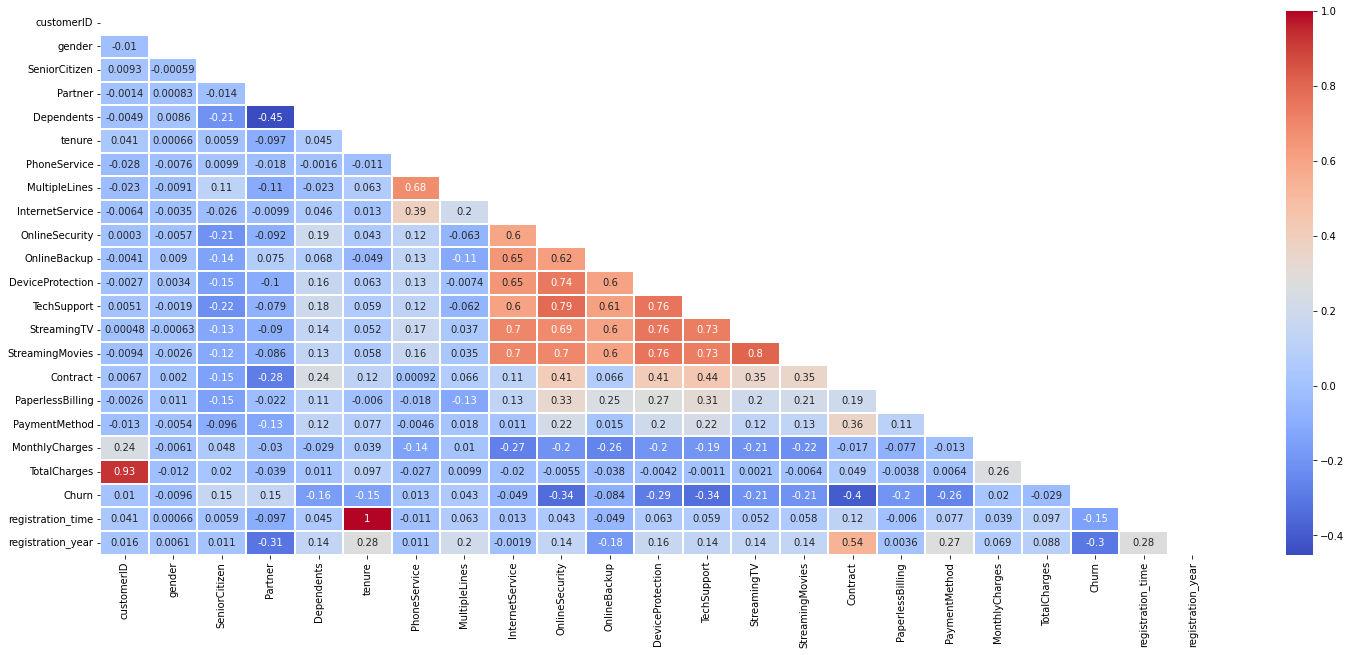

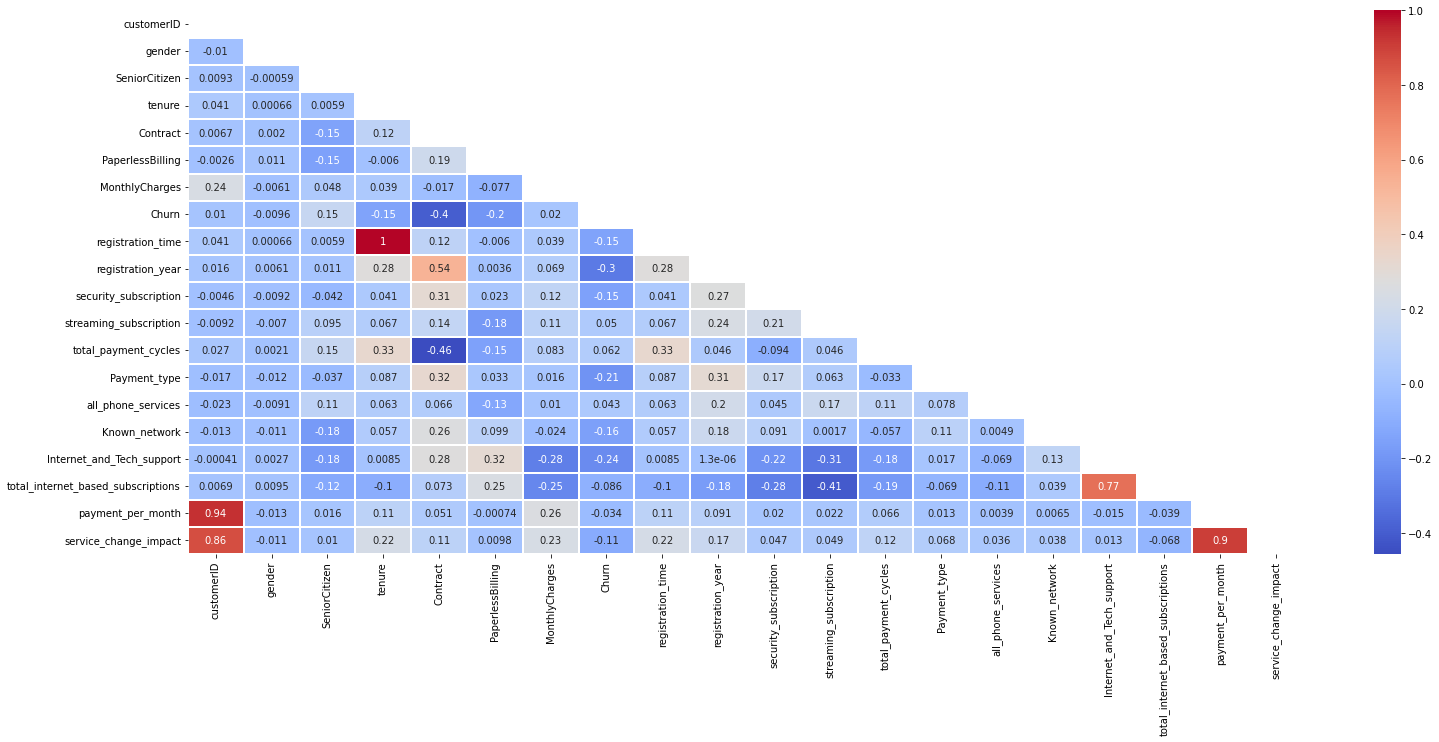

In [107]:
df_cleaned= cleaned_data(df)
correlation_plot(df_cleaned)
improvised_features=feature_engineering(df_cleaned)
correlation_plot(improvised_features)

### Observation

> The difference between first correlation diagram and second correlation diagram is mainly related to the number of variables that are highly correlated. In the first diagram, we have a lot of variables showing high correlation with each other. However, when trying to train a mode on such data sets, there is generally a bias created towards these correlations and the results are not trustworthy.


## Feature Selection

In [127]:
def train_test_split_data(data):
    data = pd.get_dummies(data, columns=[col for col in data.columns if data[col].dtypes == 'object' and col !='customerID'])

    x=data[[col for col in data.columns if col not in ['customerID', 'registration_time','Churn']]]
    y=data['Churn']
    X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2, stratify=y)
    return X_train,X_test,y_train,y_test ,data

In [128]:
X_train,X_test,y_train,y_test, data_with_dummies=train_test_split_data(improvised_features)

In [129]:
## Function to get the best 6 features using Random Forest Classifier

def get_top_6_features(X_train,X_test,y_train,y_test):
    sel = RandomForestClassifier(n_estimators=500, random_state=0)
    sel.fit(X_train, y_train)
    feature_scores = pd.Series(sel.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    
    f, ax = plt.subplots(figsize=(30, 24))
    ax = sns.barplot(x=feature_scores, y=feature_scores.index)
    ax.set_title("Visualize feature scores of the features")
    ax.set_yticklabels(feature_scores.index)
    ax.set_xlabel("Feature importance score")
    ax.set_ylabel("Features")
    plt.show()
    return feature_scores

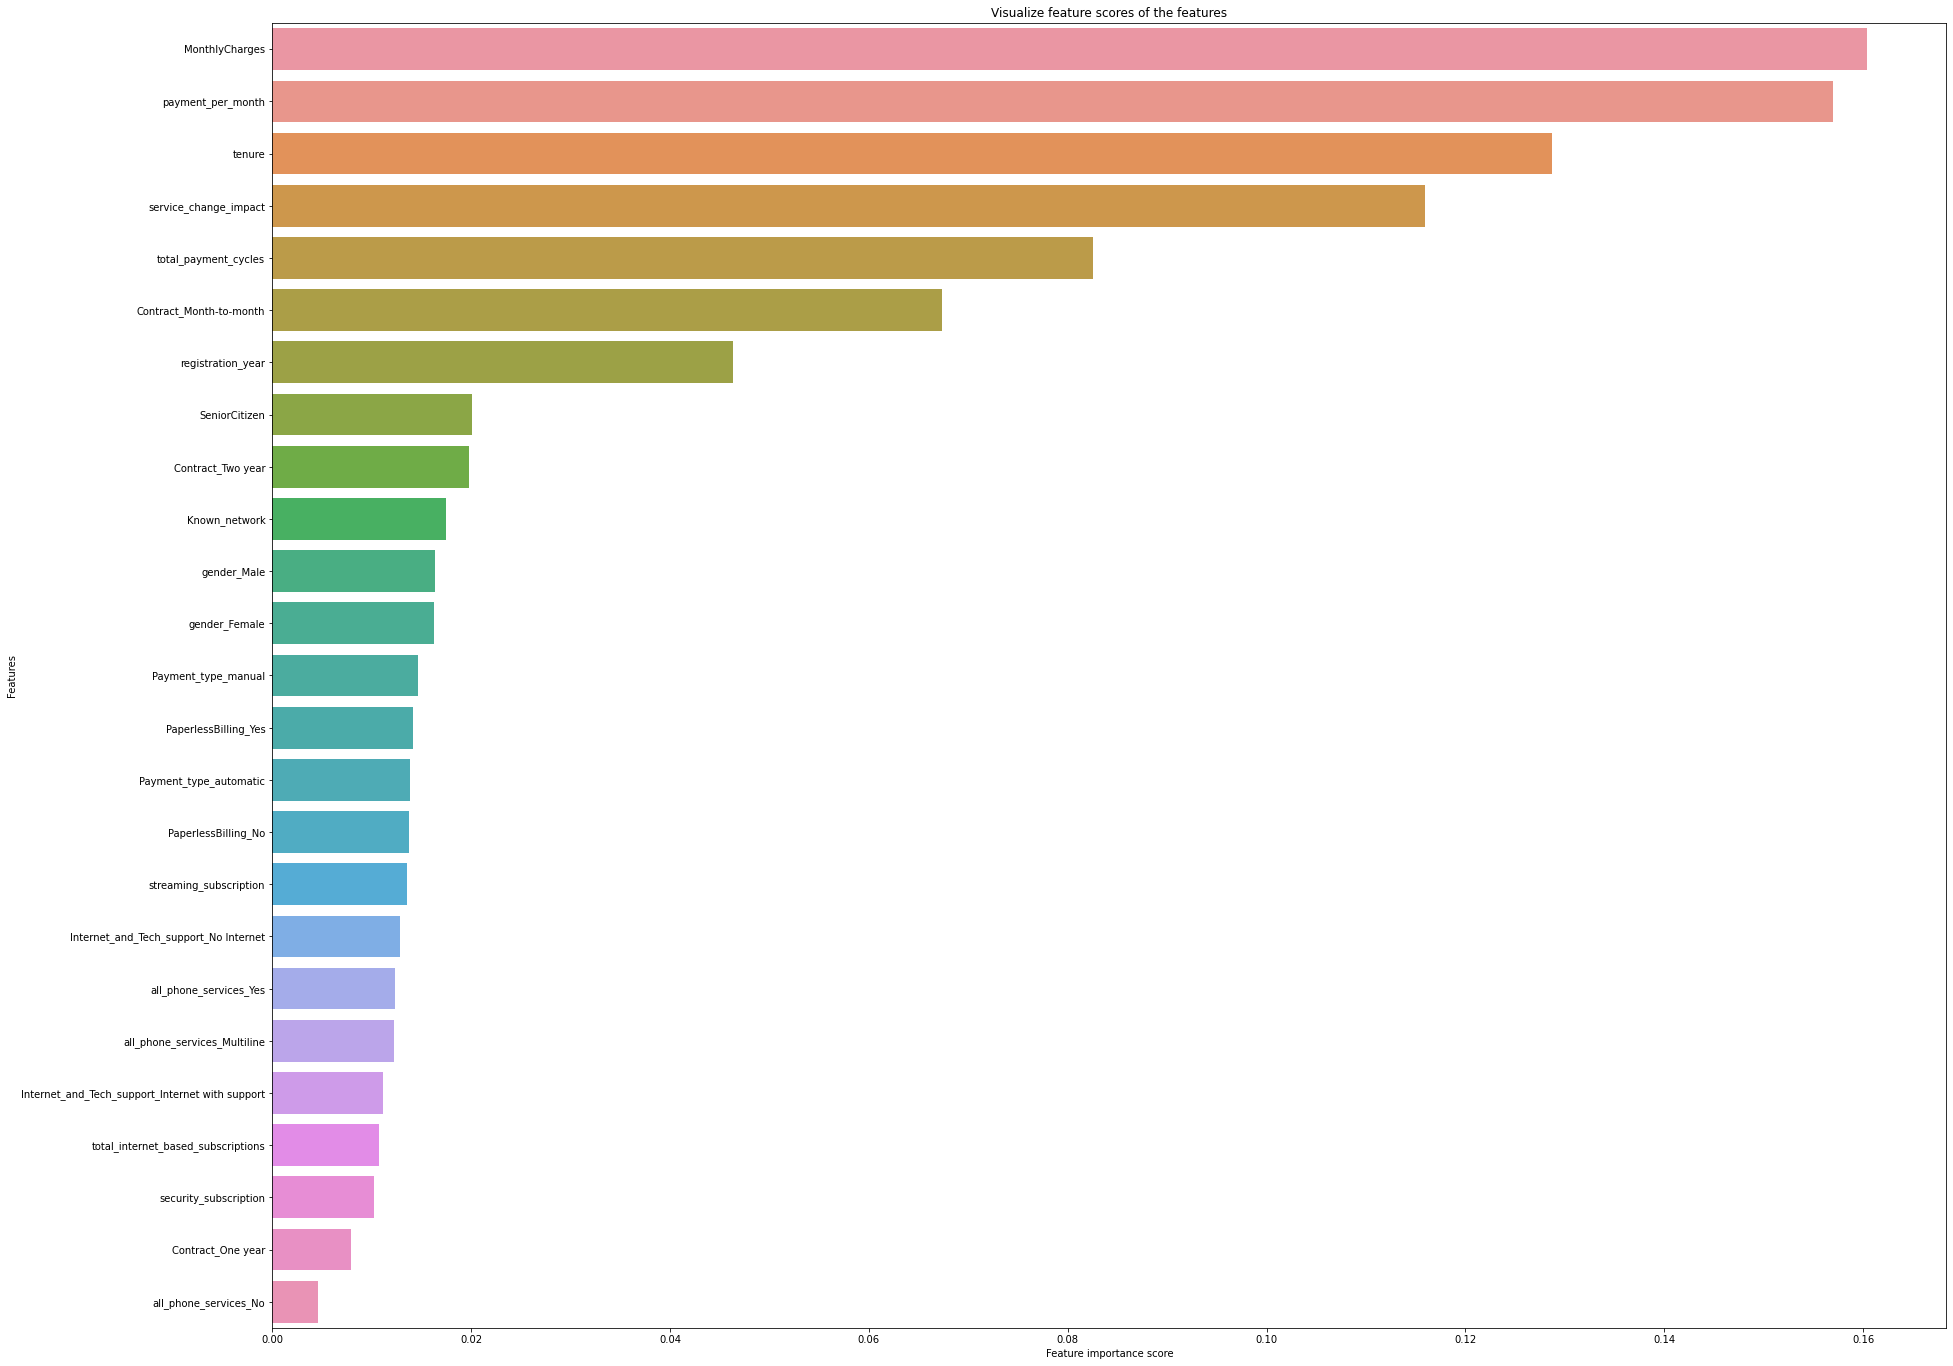

In [130]:
feature_scores=get_top_6_features(X_train,X_test,y_train,y_test)

## AutoML using TPOT Classifier

In [133]:
def autoML_for_best_model(feature_scores, data):
    x_updated=  data[feature_scores.reset_index()['index'][:6].values]
    y_updated=data['Churn']
    X_train,X_test,y_train,y_test = train_test_split(x_updated,y_updated,test_size=0.15, stratify=y_updated)
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)
    # define search
    model = TPOTClassifier(generations=10, population_size=100, cv=cv, scoring='accuracy', verbosity=2, random_state=1)
    # perform the search
    model.fit(X_train, y_train)
    return x_updated,y_updated



In [134]:
x_updated,y_updated=autoML_for_best_model(feature_scores, data_with_dummies)

                                                                                                                                                                                                                                       
Generation 1 - Current best internal CV score: 0.7937108386249794
                                                                                                                                                                                                                                       
Generation 2 - Current best internal CV score: 0.7937108386249794
                                                                                                                                                                                                                                       
Generation 3 - Current best internal CV score: 0.7937108386249794
                                                                                                          

## Model training

In [180]:
def training_on_xgb_classifier(train_data, train_labels):
    X_train,X_test,y_train,y_test = train_test_split(train_data, train_labels,test_size=0.15, stratify=train_labels)
    xgbc = XGBClassifier(learning_rate=0.01, max_depth=4, min_child_weight=4, n_estimators=100, n_jobs=1, subsample=0.1, verbosity=1)
    xgbc.fit(X_train, y_train)
    #score_train = xgbc.score(X_train, y_train)
    
    #print('Mean Accuracy on the given train data: {0:0.2f}%'.format(score_train*100))

    return xgbc,X_train,X_test,y_train,y_test



In [181]:
trained_model, X_train,X_test,y_train,y_test=training_on_xgb_classifier(x_updated,y_updated)

In [207]:
def testing_set(model,X_test,y_test):    
    score_test= model.score(X_test,y_test)
    print('Mean Accuracy on the given test data: {0:0.2f}%'.format(score_test*100))
    y_pred = model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:, 1]
    print('Precision score on the given test data: ',precision_score(y_test, y_pred))
    recall_score(y_test, y_pred)
    print('Recall score on the given test data: ',precision_score(y_test, y_pred))
    print('Confusion Matrix on the given test data:\n ',confusion_matrix(y_test, y_pred),'\n')
    print('Classification Report is as follows:\n', classification_report(y_test,y_pred),'\n')
    print('AUC/ROC score: ', roc_auc_score(y_test,y_pred_prob ))

In [189]:
testing_set(trained_model,X_test,y_test)

Mean Accuracy on the given test data: 78.41%
Precision score on the given test data:  0.6417112299465241
Recall score on the given test data:  0.6417112299465241
Confusion Matrix on the given test data:
  [[690  67]
 [156 120]] 

Classification Report is as follows:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       757
           1       0.64      0.43      0.52       276

    accuracy                           0.78      1033
   macro avg       0.73      0.67      0.69      1033
weighted avg       0.77      0.78      0.77      1033



In [184]:
def cross_validation_on_model(model, data_x,data_y):
    stratifiedkf=StratifiedKFold(n_splits=5)
    score=cross_val_score(model, data_x, data_y, cv=stratifiedkf)
    print("Cross Validation Scores are {}".format(score))
    print("Average Cross Validation score :{}".format(score.mean()))
    

In [185]:
cross_validation_on_model(trained_model,x_updated,y_updated)

Cross Validation Scores are [0.80755265 0.79012346 0.77124183 0.79738562 0.79578488]
Average Cross Validation score :0.7924176884362704


## Hyperparameter Tuning

In [191]:
def hyperparameter_tuning(train_data,train_label):
    param_grid = {'min_child_weight': [3,4,5],
        'gamma': [0.005,0.01,0.1,0.2],
        'subsample': [0.1,0.2,0.5],
        'colsample_bytree': [0.4,0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
                  'n_estimators':[100,150,200]
                 }

    grid = GridSearchCV(XGBClassifier(), param_grid, refit = True, verbose =2 )
    grid.fit(train_data,train_label)
    print(grid.best_params_)
    print(grid.best_estimator_)
    return grid.best_params_


In [192]:
params_dict=hyperparameter_tuning(x_updated,y_updated)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, g

[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, su

[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, su

[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, su

[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, su

[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=100, su

[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, su

[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=

[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=150, subsample=

[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=

[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=

[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=200, subsample=

[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=

[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.2; tot

[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.1; tot

[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.2; tot

[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.5; tot

[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.1; tot

[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.2; tot

[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.5; tot

[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.1; tot

[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.2; tot

[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.5; tot

[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.1; tot

[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.2; tot

[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=100, su

[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, su

[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, su

[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, su

[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, su

[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, su

[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, su

[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=

[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=

[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=

[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=

[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=

[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=

[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; tot

[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; tot

[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; tot

[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; tot

[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; tot

[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; tot

[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.2; tot

[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; tot

[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; tot

[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; tot

[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; tot

[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.1; tot

[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, su

[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, su

[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=150, su

[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, su

[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, su

[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=150, su

[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.005, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsam

[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=

[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=3, min_child_weight=5, n_estimators=200, subsample=

[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=150, subsample=

[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=

[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=100, subsample=

[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=

[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; tot

[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; tot

[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; tot

[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.5; tot

[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.1; tot

[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.2; tot

[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.5; tot

[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.1; tot

[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.2; tot

[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=100, subsample=0.5; tot

[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.1; tot

[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=0.8, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; tot

[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=3, n_estimators=200, su

[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=3, min_child_weight=5, n_estimators=100, su

[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=3, n_estimators=150, su

[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=4, min_child_weight=4, n_estimators=200, su

[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=3, n_estimators=150, su

[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.2; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.005, max_depth=5, min_child_weight=4, n_estimators=200, su

[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=3, n_estimators=100, subsample=

[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=3, min_child_weight=4, n_estimators=200, subsample=

[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=3, n_estimators=100, subsample=

[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=4, n_estimators=150, subsample=

[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=

[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=4, n_estimators=150, subsample=

[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=

[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=4, n_estimators=150, subsample=0.2; tot

[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=200, subsample=0.5; tot

[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=4, n_estimators=150, subsample=0.1; tot

[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=4, min_child_weight=5, n_estimators=200, subsample=0.2; tot

[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.5; tot

[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.1; tot

[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=4, n_estimators=100, subsample=0.2; tot

[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=3, min_child_weight=5, n_estimators=150, subsample=0.5; tot

[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.1; tot

[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=4, min_child_weight=5, n_estimators=150, subsample=0.2; tot

[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.2; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=3, n_estimators=200, subsample=0.5; tot

[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.2, max_depth=5, min_child_weight=5, n_estimators=150, subsample=0.1; tot

In [208]:
def training_on_optimum_hyperparameters(train_data, train_labels, min_child_weight, learning_rate, subsample, colsample_bytree, max_depth,n_estimators ):
    X_train,X_test,y_train,y_test = train_test_split(train_data, train_labels,test_size=0.15)
    xgbc = XGBClassifier(learning_rate=learning_rate,colsample_bytree=colsample_bytree, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample, n_estimators=n_estimators,verbosity=1)
    xgbc.fit(X_train, y_train)
    return xgbc,X_train,X_test,y_train,y_test

In [209]:
hypertuned_model, X_train,X_test,y_train,y_test=training_on_optimum_hyperparameters(x_updated,y_updated,params_dict['min_child_weight'],params_dict['gamma'],params_dict['subsample'],params_dict['colsample_bytree'],params_dict['max_depth'],params_dict['n_estimators'])
testing_set(hypertuned_model,X_test,y_test)


Mean Accuracy on the given test data: 76.67%
Precision score on the given test data:  0.6
Recall score on the given test data:  0.6
Confusion Matrix on the given test data:
  [[654  92]
 [149 138]] 

Classification Report is as follows:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       746
           1       0.60      0.48      0.53       287

    accuracy                           0.77      1033
   macro avg       0.71      0.68      0.69      1033
weighted avg       0.75      0.77      0.76      1033
 

AUC/ROC score:  0.8150017281482658


In [196]:
def cross_validation_on_hypertuned_model(model, data_x,data_y):
    stratifiedkf=StratifiedKFold(n_splits=5)
    cross_val_score(model, x_updated, y, cv=stratifiedkf)
    print("Cross Validation Scores are {}".format(score))
    print("Average Cross Validation score :{}".format(score.mean()))

In [197]:
cross_validation_on_model(hypertuned_model, x_updated,y_updated)

Cross Validation Scores are [0.79520697 0.78503994 0.76688453 0.79448076 0.78633721]
Average Cross Validation score :0.785589881947611


## Understanding the output

In [229]:
# Interpretation of the output

final_predictions= X_test.copy()
final_predictions['churn_flag']=y_test
final_predictions['y_pred_prob']= hypertuned_model.predict_proba(X_test)[:, 1]
tempdata=final_predictions.sort_values(by=['y_pred_prob']).reset_index()
tempdata['pred_prob_decile']=pd.qcut(tempdata.y_pred_prob,q=10,labels=list(range(10,110,10)))

print('No. of customers for analysis:', tempdata.shape[0])

aggregate_df = pd.DataFrame(tempdata.groupby('pred_prob_decile').aggregate({'y_pred_prob':'first'}))


df_decile = pd.DataFrame(tempdata.groupby('pred_prob_decile').aggregate({'y_pred_prob':'last',
                                                                        'index':'count',
                                                                        'churn_flag':'sum'}))


aggregate_df=pd.merge(aggregate_df,df_decile, how='left', on='pred_prob_decile')
aggregate_df= aggregate_df.rename(columns={'y_pred_prob_x':'Starting Probability','y_pred_prob_y':'Ending Probability','index':'Total Users','churn_flag':'Users that actually churned'})

No. of customers for analysis: 1033


In [230]:
aggregate_df.rename(index={10: '0-10th Percentile',
                           20: '10-20th Percentile',
                           30: '20-30th Percentile',
                           40: '30-40th Percentile',
                           50: '40-50th Percentile',
                           60: '50-60th Percentile',
                           70: '60-70th Percentile',
                           80: '70-80th Percentile',    
                           90: '80-90th Percentile',  
                           100: '90-100th Percentile',  
                            })

,Starting Probability,Ending Probability,Total Users,Users that actually churned
pred_prob_decile,,,,
0-10th Percentile,0.003557,0.016215,104,0
10-20th Percentile,0.016249,0.037832,103,2
20-30th Percentile,0.037988,0.066516,103,8
30-40th Percentile,0.067170,0.111907,103,11
40-50th Percentile,0.113599,0.188092,104,23
50-60th Percentile,0.191582,0.285707,103,33
60-70th Percentile,0.286141,0.386161,103,41
70-80th Percentile,0.386712,0.533034,103,42
80-90th Percentile,0.536038,0.667070,103,55


## Model Saving

In [260]:
import pickle
pickle_out = open("telecom_churn_prediction.pkl", "wb")
pickle.dump(hypertuned_model, pickle_out)
pickle_out.close()